In [1]:
!pip install prophet

In [4]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
import requests
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

**PART 1:** Exploratory Data Analysis

Average Daily Gas Prices

In [38]:
# read in daily gas prices
y = pd.read_csv('export-AvgGasPrice.csv')
y['Date(UTC)'] = pd.to_datetime(y['Date(UTC)'])
y = y.rename({'Date(UTC)':'date', 'Value (Wei)': 'value_wei'}, axis=1) # value in wei
y = y.drop('UnixTimeStamp', axis=1)

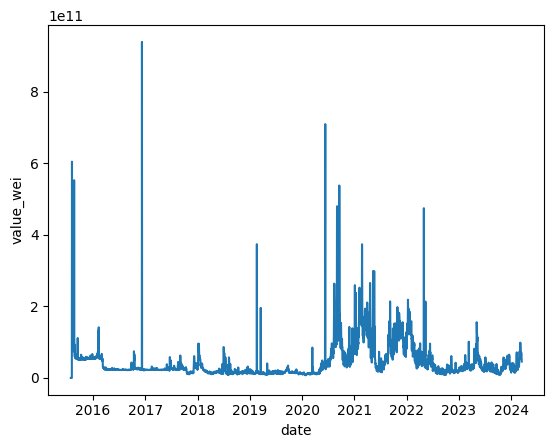

In [6]:
# plot daily prices
plt.plot(y['date'], y['value_wei'])
plt.xlabel('date')
plt.ylabel('value_wei')
plt.show()

In [7]:
# summary statistics of the wei
y['value_wei'].describe()

count    3.152000e+03
mean     4.440621e+10
std      5.383614e+10
min      0.000000e+00
25%      1.680228e+10
50%      2.470650e+10
75%      5.345896e+10
max      9.395883e+11
Name: value_wei, dtype: float64

In [8]:
max_date = y['date'].loc[y['value_wei'].idxmax()]
max_amount = y['value_wei'].max()

min_date = y['date'].loc[y['value_wei'].idxmin()]
min_amount = y['value_wei'].min()

print(f'Hit max gas price of {max_amount} on {max_date}')
print(f'Hit min gas price of {min_amount} on {min_date}')

Hit max gas price of 939588332579 on 2016-12-08 00:00:00
Hit min gas price of 0 on 2015-07-30 00:00:00


Features

In [9]:
# Preprocessing for features

gas_limit = pd.read_csv('average_gas_limit.csv', parse_dates=['Date(UTC)'])
eth_price = pd.read_csv('eth_price.csv', parse_dates=['Date(UTC)'])
transaction_fee = pd.read_csv('average_daily_transaction_fee.csv', parse_dates=['Date(UTC)'])
network_util = pd.read_csv('network_utilization.csv', parse_dates=['Date(UTC)'])
daily_transactions = pd.read_csv('daily_transactions.csv', parse_dates=['Date(UTC)'])

gas_limit = gas_limit.rename({'Date(UTC)':'date', 'Value': 'gas_limit'}, axis=1)
eth_price = eth_price.rename({'Date(UTC)':'date', 'Value': 'eth_price'}, axis=1)
transaction_fee = transaction_fee.rename({'Date(UTC)':'date', 'Average Txn Fee (USD)': 'transaction_fee'}, axis=1)
network_util = network_util.rename({'Date(UTC)':'date', 'Value': 'network_util'}, axis=1)
daily_transactions = daily_transactions.rename({'Date(UTC)':'date', 'Value': 'daily_transactions'}, axis=1)

gas_limit = gas_limit.drop('UnixTimeStamp', axis=1)
eth_price = eth_price.drop('UnixTimeStamp', axis=1)
transaction_fee = transaction_fee.drop(['UnixTimeStamp', 'DateTime', 'Average Txn Fee (Ether)'], axis=1)
network_util = network_util.drop('UnixTimeStamp', axis=1)
daily_transactions = daily_transactions.drop('UnixTimeStamp', axis=1)

features = gas_limit.merge(eth_price, on='date', how='outer')
features = features.merge(transaction_fee, on='date', how='outer')
features = features.merge(network_util, on='date', how='outer')
features = features.merge(daily_transactions, on='date', how='outer')
features = features.merge(y, on='date', how='outer')

In [10]:
# check for na values
features.isna().sum()

# since there are none we don't have to do any backward or forward filling

date                  0
gas_limit             0
eth_price             0
transaction_fee       0
network_util          0
daily_transactions    0
value_wei             0
dtype: int64

In [11]:
# summary statistic of features
features[['gas_limit', 'eth_price', 'transaction_fee', 'network_util', 'daily_transactions']].describe()

,gas_limit,eth_price,transaction_fee,network_util,daily_transactions
count,3.152000e+03,3152.000000,3152.000000,3152.000000,3.152000e+03
mean,1.446973e+07,965.645787,4.887370,0.578866,7.286388e+05
std,1.062340e+07,1116.744795,9.983084,0.316462,4.450301e+05
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
25%,6.716664e+06,136.195000,0.090000,0.502900,3.767412e+05
50%,9.931896e+06,354.110000,0.450000,0.514800,7.894750e+05
75%,2.999960e+07,1703.440000,4.835000,0.872525,1.111064e+06
max,3.007684e+07,4810.970000,200.060000,0.991500,1.961144e+06


In [12]:
# check correlations between features
features[['gas_limit', 'eth_price', 'transaction_fee', 'network_util', 'daily_transactions']].corr()

,gas_limit,eth_price,transaction_fee,network_util,daily_transactions
gas_limit,1.000000,0.820652,0.522267,0.088177,0.753064
eth_price,0.820652,1.000000,0.786629,0.129178,0.742107
transaction_fee,0.522267,0.786629,1.000000,0.066885,0.514898
network_util,0.088177,0.129178,0.066885,1.000000,0.642894
daily_transactions,0.753064,0.742107,0.514898,0.642894,1.000000


In [39]:
# train/ test split keeping time series
split_point = int(len(y) * 0.8)
y_train, y_test = y[:split_point], y[split_point:]

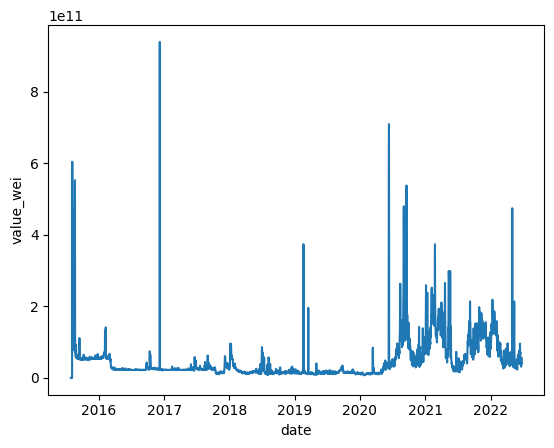

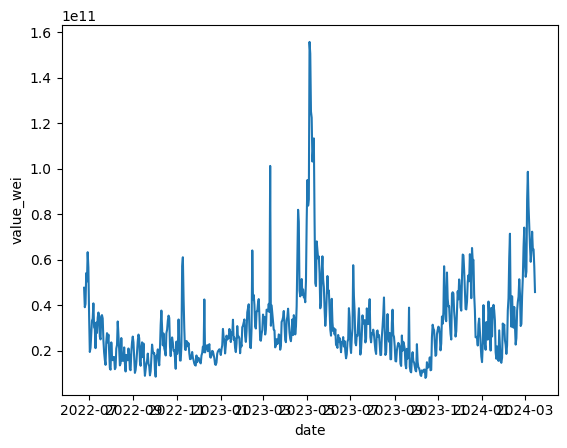

In [14]:
# plot the train and test sets

plt.plot(y_train['date'], y_train['value_wei'])
plt.xlabel('date')
plt.ylabel('value_wei')
plt.show()

plt.plot(y_test['date'], y_test['value_wei'])
plt.xlabel('date')
plt.ylabel('value_wei')
plt.show()

**Part 2:** ARIMA Model

In [15]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# check stationarity of the data set
def check_stationarity(series, sig_level=0.05):
    result = adfuller(series, autolag='AIC')
    if result[1] < sig_level:
        print(f"The series is stationary (p-value: {result[1]}).")
    else:
        print(f"The series is not stationary (p-value: {result[1]})")

check_stationarity(y['value_wei'])
# From this we set d = 0

The series is stationary (p-value: 2.8510949032756516e-07).


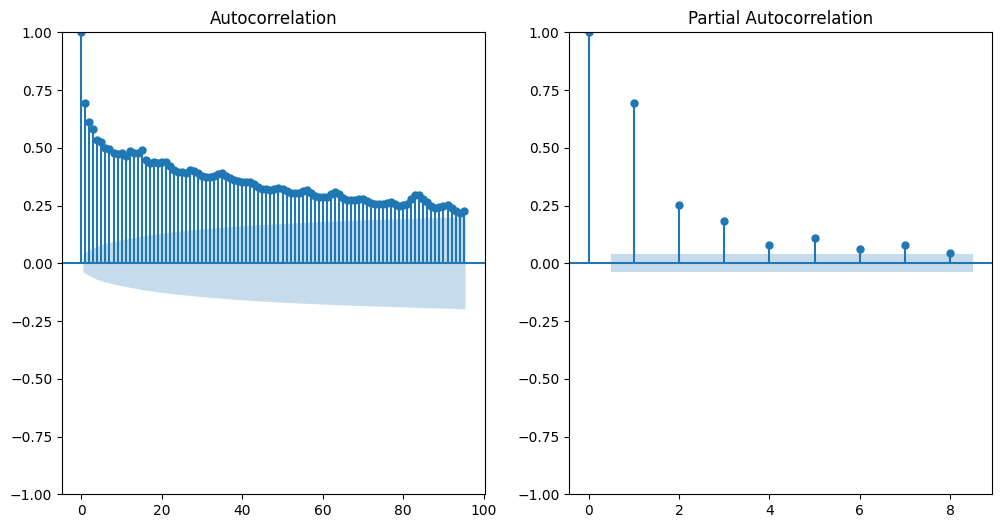

In [16]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot autocorrelations
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(y_train['value_wei'], ax=plt.gca(), lags=95)

# from this we set p = 5

plt.subplot(122)
plot_pacf(y_train['value_wei'], ax=plt.gca(), lags=8)
plt.show()

# from this set q = 0

In [41]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm

predictions_arima = []

# perform walk-forward validation
for t in tqdm(range(split_point, len(y))):

    # train the model on iteratively added data
    model = ARIMA(y['value_wei'][:t], order=(5,0,0))
    model_fit = model.fit()

    # Forecast the next time point
    forecast = model_fit.forecast(steps=1)
    predictions_arima.append(forecast.iloc[0])

100%|██████████| 631/631 [06:29<00:00,  1.62it/s]


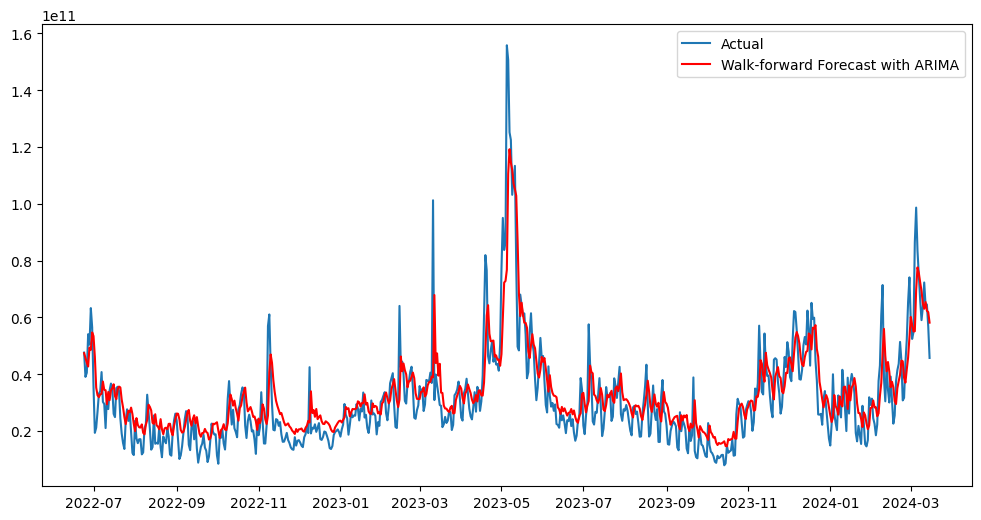

In [42]:
plt.figure(figsize=(12,6))
plt.plot(y_test['date'], y_test['value_wei'], label='Actual')
plt.plot(y_test['date'], predictions_arima, color='red', label='Walk-forward Forecast with ARIMA')
plt.legend()
plt.show()

**Part 3:** Prophet Model

In [19]:
from prophet import Prophet
import datetime as dt
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation

# Prophet expects the columns to be named 'ds' for the date and 'y' for the value
y_new = y.rename(columns={'date': 'ds', 'value_wei': 'y'})

model = Prophet()
model.fit(y_new)

df_cv = cross_validation(model, initial=f'{split_point - 1} days', period='1 days', horizon = '1 days')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmr8p484r/jbe5cvco.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmr8p484r/sxkgjwu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76600', 'data', 'file=/tmp/tmpmr8p484r/jbe5cvco.json', 'init=/tmp/tmpmr8p484r/sxkgjwu9.json', 'output', 'file=/tmp/tmpmr8p484r/prophet_model57wbpmi2/prophet_model-20240507130203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:02:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:02:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 631 forecasts with cutoffs between 2022-06-23 00:00:00 and 2024-03-14 00:00:00


  0%|          | 0/631 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93132', 'data', 'file=/tmp/tmpmr8p484r/8fh5bdeq.json', 'init=/tmp/tmpmr8p484r/hqvffobh.json', 'output', 'file=/tmp/tmpmr8p484r/prophet_modelypex_5w5/prophet_model-20240507130307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmr8p484r/1b2ib0au.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmr8p484r/nrxz2734.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7734', 'data', 'file=/tmp/tmpmr8p484r/1b2ib0au.json', 'init=/tmp

In [20]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-06-24,5.972385e+10,4.136786e+09,1.160253e+11,47629295462,2022-06-23
1,2022-06-25,5.411186e+10,-4.743857e+09,1.153298e+11,39063860247,2022-06-24
2,2022-06-26,5.254034e+10,-1.019911e+10,1.106918e+11,40520495410,2022-06-25
3,2022-06-27,5.852394e+10,-7.260346e+08,1.174183e+11,54099913325,2022-06-26
4,2022-06-28,5.879571e+10,-3.754623e+07,1.205033e+11,50397241148,2022-06-27
...,...,...,...,...,...,...
626,2024-03-11,2.543940e+10,-3.213601e+10,7.803453e+10,72310953858,2024-03-10
627,2024-03-12,2.717718e+10,-2.519242e+10,8.321345e+10,64385923989,2024-03-11
628,2024-03-13,2.961225e+10,-2.751892e+10,8.163239e+10,64569491149,2024-03-12
629,2024-03-14,3.217880e+10,-2.204760e+10,8.462230e+10,56888536551,2024-03-13


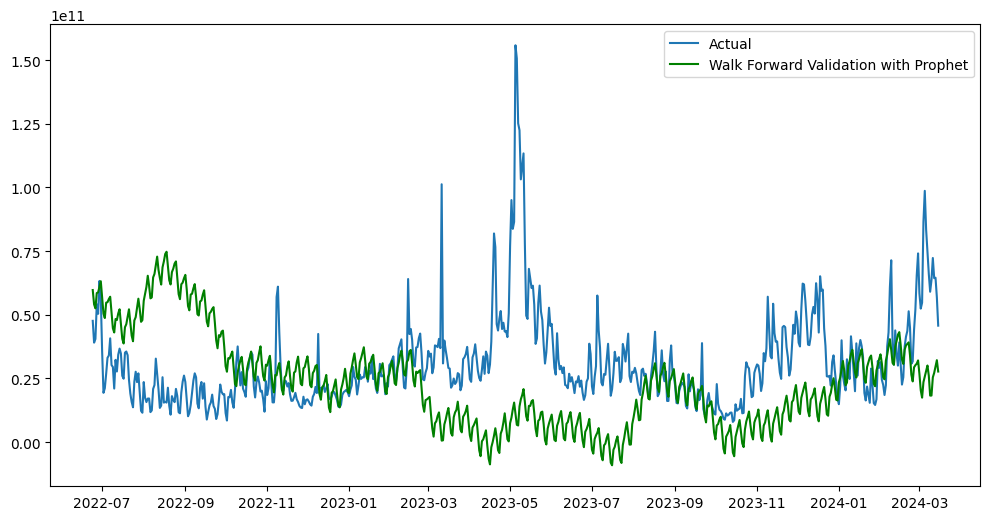

In [21]:
plt.figure(figsize=(12,6))
plt.plot(df_cv['ds'],  df_cv['y'], label='Actual')

# Predicted values, note the slicing to align the dates correctly
plt.plot(df_cv['ds'],  df_cv['yhat'], color='green', label='Walk Forward Validation with Prophet')

plt.legend()
plt.show()

**PART 4:** LSTM Model

In [66]:
# Combine all feature datasets into a single DataFrame by date
data_lstm = features.merge(y, on='date', how='outer')

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_x.fit_transform(data_lstm.iloc[:, 1:-1])
scaled_y = scaler_y.fit_transform(data_lstm.iloc[:, -1].values.reshape(-1, 1))

# Prepare the combined dataset for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 5 # like ARIMA
X_lstm, y_lstm = create_dataset(scaled_features, scaled_y, time_steps)

# Split into train and test sets the 5 is to make sure we get the same test set sizes as above
split_point = int(len(data_lstm) * 0.8) - 5

X_train, X_test = X_lstm[:split_point], X_lstm[split_point:]
y_train, y_test = y_lstm[:split_point], y_lstm[split_point:]

In [67]:
# we first try a train once and predict using same model! (no weight updates with the inclusion of new data unlike ARIMA)

# build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform to original scale for y
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

Epoch 1/20
79/79 [==============================] - 6s 19ms/step - loss: 0.0029 - val_loss: 4.0240e-04
Epoch 2/20
79/79 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 3/20
79/79 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 2.2762e-04
Epoch 4/20
79/79 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 3.9248e-04
Epoch 5/20
79/79 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 1.7606e-04
Epoch 6/20
79/79 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 2.1316e-04
Epoch 7/20
79/79 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 2.2162e-04
Epoch 8/20
79/79 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 2.9762e-04
Epoch 9/20
79/79 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 1.4987e-04
Epoch 10/20
79/79 [==============================] - 1s 8ms/step - loss: 0.0019 - val

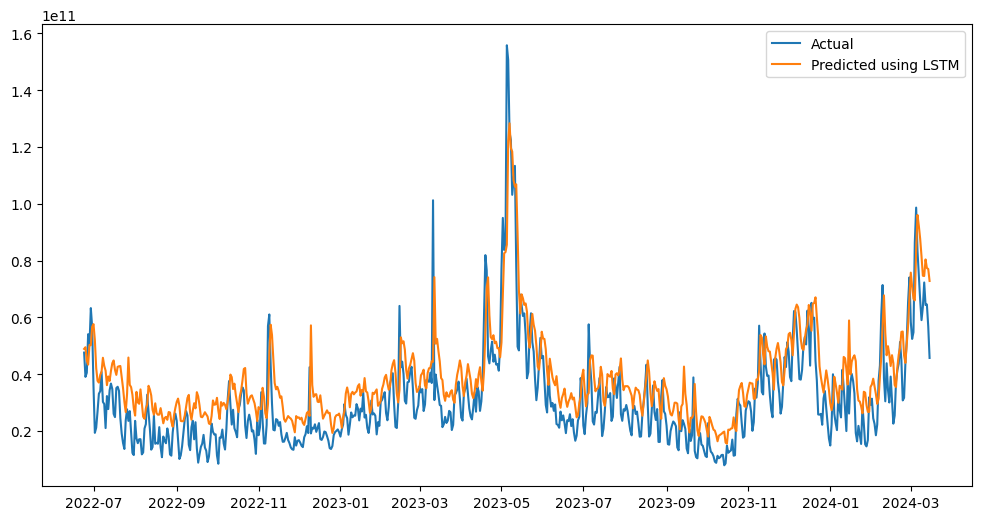

In [68]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(y['date'][split_point + 5:], y_test_inv.flatten(), label='Actual')
plt.plot(y['date'][split_point + 5:], y_pred_inv.flatten(),  label="Predicted using LSTM")
plt.legend()
plt.show()

In [ ]:
from tqdm import tqdm

# now lets implement walk-forward (the walk-forward takes too much memory so cannot be done)

def model_fit_lstm(X, y):
  model = Sequential()
  model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
  model.add(LSTM(50))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(X, y, epochs=20, batch_size=32, verbose=0)

  return model

predictions_lstm_walk_forward = []

for t in tqdm(range(split_point, len(y_lstm))):

    # train the model on iteratively added data
    X_new_train = X_lstm[:t]
    y_new_train = y_lstm[:t]

    model = model_fit_lstm(X_new_train, y_new_train)

    forecast = model.predict(np.array([X_lstm[t]]))
    forecast_inv = scaler_y.inverse_transform(forecast.reshape(1, -1)).flatten()[0]

    predictions_lstm_walk_forward.append(forecast_inv)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y['date'][split_point + 5:], y_test_inv.flatten(), label='Actual')
plt.plot(y['date'][split_point + 5:], predictions_lstm_walk_forward,  label="Predicted using LSTM")
plt.legend()
plt.show()

**Part 5:** Error Metrics

In [69]:
# Results may be slightly different due to randomness in training

from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score

def error_metrics(predictions, actual):
  '''Provides the Mean Squared Error,
                  Root Mean Squared Error,
                  Mean Absolute Error,
                  R2 Score for the predicted and actual'''

  mse = mean_squared_error(predictions, actual)
  rmse = mean_squared_error(predictions,  actual, squared=False)
  mae = mean_absolute_error(predictions, actual)
  r2 = r2_score(predictions, actual)

  return mse, rmse, mae, r2

mse_arima, rmse_arima, mae_arima, r2_arima = error_metrics(predictions_arima, df_cv['y'])
mse_prophet, rmse_prophet, mae_prophet, r2_prophet = error_metrics(df_cv['yhat'], df_cv['y'])
mse_lstm, rmse_lstm, mae_lstm, r2_lstm = error_metrics(y_pred_inv.flatten(), y_test_inv.flatten())

In [70]:
print('ARIMA')
print(f'Test MSE: {np.round(mse_arima, 3)}')
print(f'Test RMSE: {np.round(rmse_arima, 3)}')
print(f'Test MAE: {np.round(mae_arima, 3)}')
print(f'Test R2: {np.round(r2_arima, 3)}')

ARIMA
Test MSE: 9.539906947469835e+19
Test RMSE: 9767244722.781
Test MAE: 6960425639.968
Test R2: 0.517


In [71]:
print('Prophet')
print(f'Test MSE: {np.round(mse_prophet, 3)}')
print(f'Test RMSE: {np.round(rmse_prophet, 3)}')
print(f'Test MAE: {np.round(mae_prophet, 3)}')
print(f'Test R2: {np.round(r2_prophet, 3)}')

Prophet
Test MSE: 7.939560275133879e+20
Test RMSE: 28177225333.829
Test MAE: 20739860062.928
Test R2: -1.499


In [72]:
print('LSTM')
print(f'Test MSE: {np.round(mse_lstm, 3)}')
print(f'Test RMSE: {np.round(rmse_lstm, 3)}')
print(f'Test MAE: {np.round(mae_lstm, 3)}')
print(f'Test R2: {np.round(r2_lstm, 3)}')

LSTM
Test MSE: 1.576778683959373e+20
Test RMSE: 12556984844.935
Test MAE: 10233754548.539
Test R2: 0.336


**Part 6:** Future Work / What Future Work Could Look Like

In [56]:
# here we implement a version of ARIMA

def get_current_gas_price():
  '''
  Returns the current gas price on the market leveraging API (could be Etherscan)
  (since we don't have access to API (paid) we simply return a random number)
  '''

  return 45740465011

def get_historical_gas_price(start_date=dt.datetime(2015, 1, 1), end_date=dt.datetime.now()):
  '''
  Returns the time series of historical average daily gas prices from start date
  to end date leveraging API (could again be Etherscan)
  (since we don't have access we simply return the data we used)

  '''

  # REPLACE BELOW
  y = pd.read_csv('export-AvgGasPrice.csv')
  y['Date(UTC)'] = pd.to_datetime(y['Date(UTC)'])
  y = y.rename({'Date(UTC)':'date', 'Value (Wei)': 'value_wei'}, axis=1) # value in wei
  y = y.drop('UnixTimeStamp', axis=1)

  return y

def get_predicted_average_daily_gas_price(days=1):
  '''
  Returns the predicted average daily gas price for the next days
  '''
  y = get_historical_gas_price()
  model = ARIMA(y['value_wei'], order=(5,0,0))
  model_fit = model.fit()

  forecast = model_fit.forecast(steps=days)
  return forecast

In [57]:
current = get_current_gas_price()
forecast = get_predicted_average_daily_gas_price()

print(f'Current: {current}')
print(f'Forecast: {forecast.iloc[0]}')
if current > forecast.iloc[0]:
  print('The current gas price is higher than today\'s average gas price forecast. Please wait a few.')
else:
  print('The current gas price is lower than today\'s average gas price forecast.')

Current: 45740465011
Forecast: 52852732307.75882
The current gas price is lower than today's average gas price forecast.


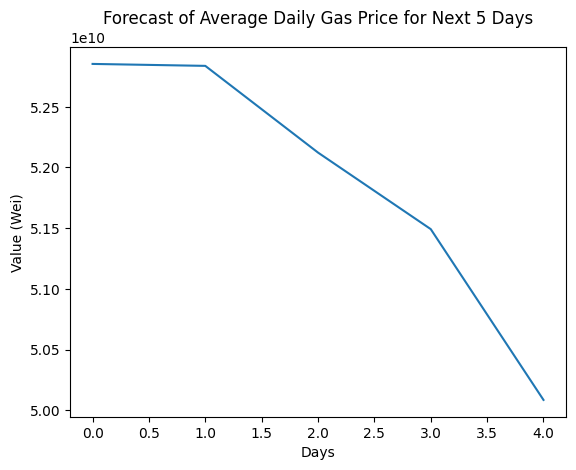

In [59]:
# days can be changed
days=5
next_few_days = get_predicted_average_daily_gas_price(days=days)

plt.plot(range(len(next_few_days)), next_few_days, label='Forecast')
plt.xlabel('Days')
plt.ylabel('Value (Wei)')
plt.title(f'Forecast of Average Daily Gas Price for Next {days} Days')
plt.show()